<a href="https://colab.research.google.com/github/thinhngo-x/deep-learning/blob/master/TD4_WeightsInitialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import math
import numpy as np

<class 'torch.Tensor'>


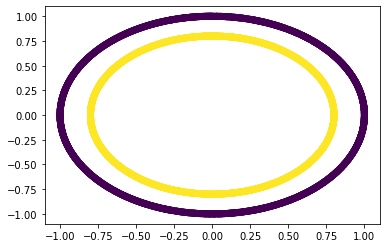

In [0]:
X,y = make_circles(5000)
training_size = int(5000 * 0.8)
dataset = TensorDataset(torch.tensor(X),torch.tensor(y))
train_data = dataset[0:training_size]
test_data = dataset[(training_size+1):-1]
X_train, y_train = train_data
X_test, y_test = test_data
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
print(type(X_train))

$\nabla_{\mathbf{X}} g(f(\mathbf{X})) = \nabla_{\mathbf{X}} f^T \nabla_{f}g$

In [0]:
sigmoid = lambda x : 1 / (1+torch.exp(-x))
d_sigmoid = lambda y : y * (1-y)

class Neural_Network(nn.Module):
    def __init__(self, lr=1.0, activation = sigmoid, d_activation = d_sigmoid):
        super(Neural_Network, self).__init__()
        self.inputSize = 2
        self.hiddenSize = 10
        self.outputSize = 1
        self.lr = lr

        # weights
        self.W1 = torch.randn(self.inputSize, self.hiddenSize)
        self.W2 = torch.randn(self.hiddenSize, self.outputSize)
        self.b1 = torch.randn(1, self.hiddenSize)
        self.b2 = torch.randn(1, self.outputSize)
        self.activation = activation
        self.d_activation = d_activation


    def forward(self, X):
        self.z1 = torch.matmul(X, self.W1)+self.b1
        self.a1 = self.activation(self.z1)
        self.z2 = torch.matmul(self.a1, self.W2) +self.b2
        self.a2 = self.activation(self.z2)
        return self.a2

    def backpropagate(self, X, a2, y_target):
        # commencer par:
        dE_da2 = a2 - y_target
        dE_dz2 = self.d_activation(a2) * dE_da2
        dE_dW2 = torch.matmul(torch.t(self.a1), dE_dz2)
        dE_da1 = torch.matmul(dE_dz2, torch.t(self.W2))
        dE_db2 = torch.sum(dE_dz2, dim=0)

        #update W2, b2
        self.W2 = self.W2 - self.lr * dE_dW2
        self.b2 = self.b2 - self.lr * dE_db2

        dE_dz1 = self.d_activation(self.a1) * dE_da1
        dE_dW1 = torch.matmul(torch.t(X), dE_dz1)
        dE_db1 = torch.sum(dE_dz1, dim=0)
        
        #update W1, b1
        self.W1 = self.W1 - self.lr * dE_dW1
        self.b1 = self.b1 - self.lr * dE_db1
        # completer ici
        pass

    def train(self, X, y, epoch=20, batch_size=16):
      data = torch.utils.data.DataLoader(TensorDataset(X,y), batch_size=batch_size)
      for i in tqdm(range(epoch)):
        for X,y in  data:
          tmp = self.forward(X)
          E = 0.5 * torch.matmul(torch.t(tmp-y), tmp-y)
          #print(E)
          self.backpropagate(X, tmp, y)
      pass

In [0]:
def success_rate(model, test_data):
  X_test, y_test = test_data
  y_pred = model.forward(X_test.float())
  check = [1 for i,j in zip(y_pred, y_test) if (abs(i-j)<0.5)]
  return(len(check)/len(y_test))

In [0]:
model = Neural_Network()
model.train(X_train.float(), y_train.float().reshape(-1,1))
success_rate(model, test_data)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1.0

In [0]:
from torchvision import datasets, transforms

training_data = datasets.FashionMNIST(".",download=True,train=True, transform=transforms.Compose([
                                                                                transforms.ToTensor(),
                                                                                lambda x: torch.flatten(x)
]))
test_data = datasets.FashionMNIST(".",download=True,train=False, transform=transforms.Compose([
                                                                                transforms.ToTensor(),
                                                                                lambda x: torch.flatten(x),
]))

In [0]:
def trainer(dataset,model,loss_fn,epoch=10,batch_size=1,rate=1e-4):
  loss_eval = list()
  data = torch.utils.data.DataLoader(dataset, batch_size)
  optimizer = optim.Adam(model.parameters(),lr=rate)
  j = 0
  for i in tqdm(range(epoch)):
    for imgs, labels in data:
      j += 1
      imgs = imgs
      labels = labels
      optimizer.zero_grad()
      labels = labels.float()
      output = model(imgs)
      loss = loss_fn(output, labels)
      if(j%10 == 0):
        loss_eval.append(loss.item())
      loss.backward()

      optimizer.step()
  return loss_eval

In [0]:
def xavier(weights):
  n_in = weights.size(1)
  n_out = weights.size(0)
  print(n_in, n_out)
  a = math.sqrt(6/(n_in + n_out))
  with torch.no_grad():
    return weights.uniform_(-a, a)


def init_weights_kaiming(m):
    #print(m)
    if type(m) == nn.Linear:
      nn.init.kaiming_uniform_(m.weight)
      #print(m.weight)


def init_weights_xavier(m):
  if type(m) == nn.Linear:
    xavier(m.weight)

def init_weights_constant(m):
       #print(m)
       if type(m) == nn.Linear:
          nn.init.constant_(m.weight,0)
          #print(m.weight)

def graph(title, **kwargs):
  colors = "bgrcmykw:"
  fig, ax = plt.subplots()
  
  for name,color in zip(kwargs,colors):
    ax.plot(kwargs[name],color,label=name)
  ax.set_title(title)
  ax.legend()
  plt.show()

In [0]:
net_Tanh = nn.Sequential(nn.Linear(784, 128),
                    nn.Tanh(),
                    nn.Linear(128, 10),
                    nn.Linear(10,1))

In [0]:
net_Tanh.apply(init_weights_xavier)
loss_xavier = trainer(training_data, net_Tanh, nn.MSELoss(), batch_size=256, epoch=3)

net_Tanh.apply(init_weights_kaiming)
loss_kaiming = trainer(training_data, net_Tanh, nn.MSELoss(), batch_size=256, epoch=3)

net_Tanh.apply(init_weights_constant)
loss_constant = trainer(training_data, net_Tanh, nn.MSELoss(), batch_size=256, epoch=3)

784 128
128 10
10 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


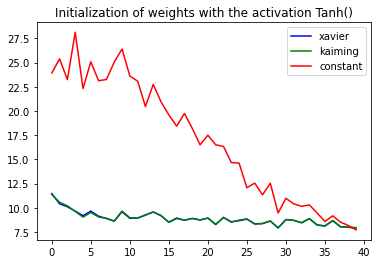

In [0]:
graph(xavier=loss_xavier[0:40],kaiming=loss_kaiming[0:40], constant=loss_constant[0:40],
      title='Initialization of weights with the activation Tanh()')

In [0]:
net_Sigmoid = nn.Sequential(nn.Linear(784, 128),
                            nn.Sigmoid(),
                            nn.Linear(128, 10),
                            nn.Linear(10,1))

In [0]:
net_Sigmoid.apply(init_weights_xavier)
loss_xavier = trainer(training_data, net_Sigmoid, nn.MSELoss(), batch_size=256, epoch=2)

net_Sigmoid.apply(init_weights_kaiming)
loss_kaiming = trainer(training_data, net_Sigmoid, nn.MSELoss(), batch_size=256, epoch=2)

net_Sigmoid.apply(init_weights_constant)
loss_constant = trainer(training_data, net_Sigmoid, nn.MSELoss(), batch_size=256, epoch=2)

784 128
128 10
10 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


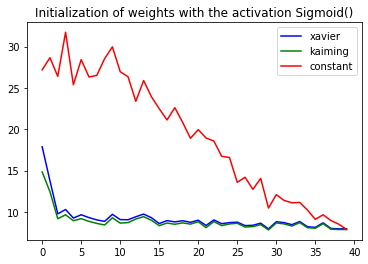

In [0]:
graph(xavier=loss_xavier[0:40],kaiming=loss_kaiming[0:40], constant=loss_constant[0:40],
      title='Initialization of weights with the activation Sigmoid()')

In [0]:
net_ReLU = nn.Sequential(nn.Linear(784, 128),
                         nn.ReLU(),
                         nn.Linear(128, 10),
                         nn.Linear(10,1))

In [0]:
net_ReLU.apply(init_weights_xavier)
loss_xavier = trainer(training_data, net_ReLU, nn.MSELoss(), batch_size=256, epoch=2)

net_ReLU.apply(init_weights_kaiming)
loss_kaiming = trainer(training_data, net_ReLU, nn.MSELoss(), batch_size=256, epoch=2)

net_ReLU.apply(init_weights_constant)
loss_constant = trainer(training_data, net_ReLU, nn.MSELoss(), batch_size=256, epoch=2)

784 128
128 10
10 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


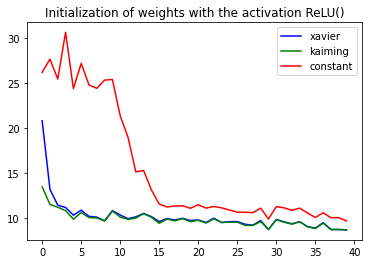

In [0]:
graph(xavier=loss_xavier[0:40],kaiming=loss_kaiming[0:40], constant=loss_constant[0:40],
      title='Initialization of weights with the activation ReLU()')